In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

100.0%
100.0%
100.0%
100.0%

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


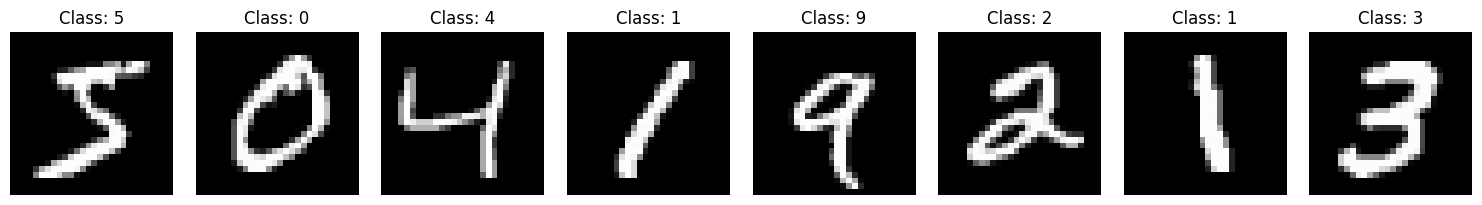

In [2]:
# MNIST Dataset
# Define transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ]
)

# Alternative transform for [0, 1] range (matches Sigmoid output)
transform_01 = transforms.Compose(
    [
        transforms.ToTensor()  # Already converts to [0, 1]
    ]
)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform_01
)

test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform_01
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


# Visualize some samples
def show_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.squeeze()  # Remove channel dimension for grayscale
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Class: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


show_images(train_dataset)

# Auto Encoder 1: Without dim reduction

In [3]:
IMAGE_DIM = 28 * 28  # MNIST images are 28x28 grayscale
LATENT_DIM = 9

In [4]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(IMAGE_DIM, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, LATENT_DIM),
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, IMAGE_DIM),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/20, Loss: 0.038530
Epoch 2/20, Loss: 0.030152
Epoch 3/20, Loss: 0.027460
Epoch 4/20, Loss: 0.026003
Epoch 5/20, Loss: 0.021386
Epoch 6/20, Loss: 0.020164
Epoch 7/20, Loss: 0.020943
Epoch 8/20, Loss: 0.018989
Epoch 9/20, Loss: 0.018156
Epoch 10/20, Loss: 0.016440
Epoch 11/20, Loss: 0.016417
Epoch 12/20, Loss: 0.015836
Epoch 13/20, Loss: 0.017260
Epoch 14/20, Loss: 0.016279
Epoch 15/20, Loss: 0.014619
Epoch 16/20, Loss: 0.015081
Epoch 17/20, Loss: 0.014158
Epoch 18/20, Loss: 0.013715
Epoch 19/20, Loss: 0.012190
Epoch 20/20, Loss: 0.014668


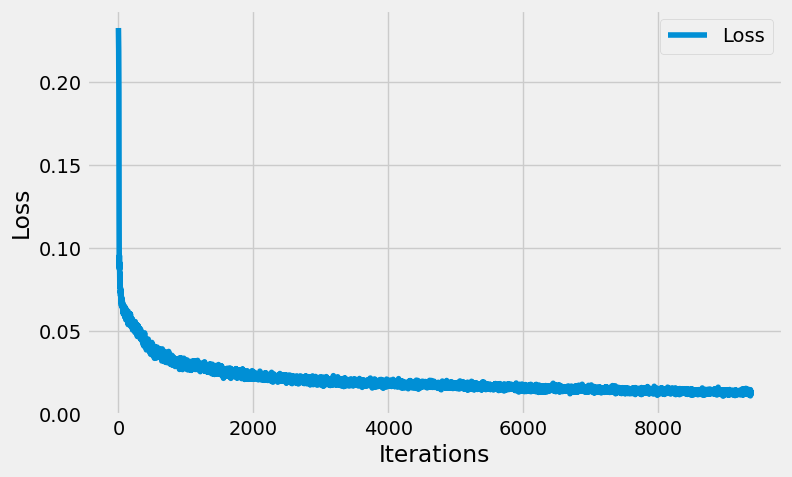

In [6]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(-1, IMAGE_DIM).to(device)

        reconstructed = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

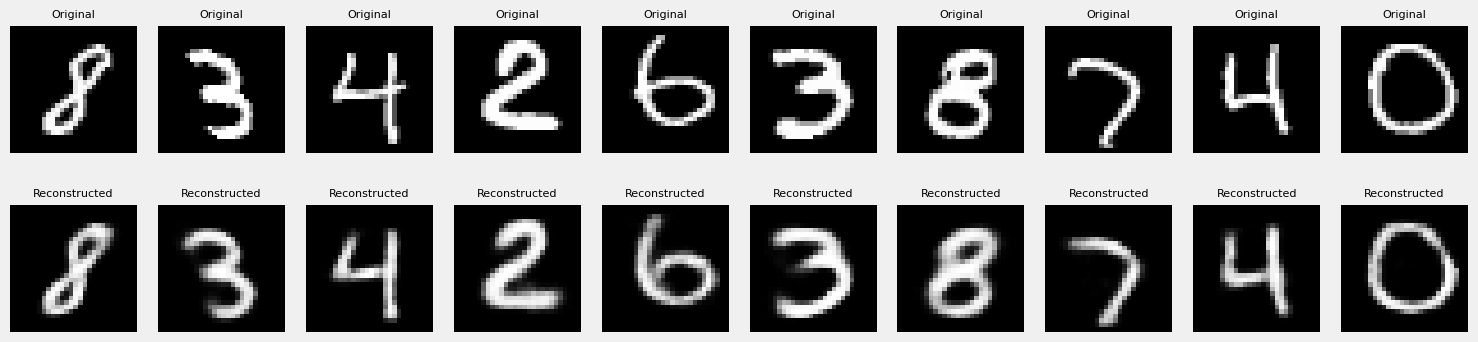

In [7]:
model.eval()
dataiter = iter(train_loader)
images, _ = next(dataiter)

images = images.view(-1, IMAGE_DIM).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
for i in range(10):
    # Original images
    img_original = images[i].cpu().detach().numpy().reshape(28, 28)
    axes[0, i].imshow(img_original, cmap='gray')
    axes[0, i].axis("off")
    axes[0, i].set_title("Original", fontsize=8)
    
    # Reconstructed images
    img_reconstructed = reconstructed[i].cpu().detach().numpy().reshape(28, 28)
    axes[1, i].imshow(img_reconstructed, cmap='gray')
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed", fontsize=8)

plt.tight_layout()
plt.show()